# Pytorch Tutorial 2: VAE (Variational AutoEncoder)



In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device: {device}')

Current device: cuda


## Model Architecture

In [3]:
class VAE(nn.Module):
    def __init__(self, x_dim, h1_dim, h2_dim, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.fc31 = nn.Linear(h2_dim, z_dim)
        self.fc32 = nn.Linear(h2_dim, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h2_dim)
        self.fc5 = nn.Linear(h2_dim, h1_dim)
        self.fc6 = nn.Linear(h1_dim, x_dim)

    def encoder(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.fc31(x), self.fc32(x) # mu, log_var

    def sampling(self, mu, log_var):
        """
            Note:
                z = mu + var * noise

            Args:
                mu (torch.Tensor):
                    mean of the sampled noise.
                log_var (torch.Tensor):
                    Logarithmic result of variance of the sampled noise.
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sampled_z = eps * std

        return sampled_z.add_(mu) # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))

        return F.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)

        return self.decoder(z), mu, log_var

In [4]:
# build model
vae = VAE(x_dim=784, h1_dim= 512, h2_dim=256, z_dim=2)
vae = vae.to(device)

## Loss Function

### You can try to learn more about the design of loss function applied in VAE. We do not introduce this part for you in our tutorial. But we could provide some keywords to help you search related info.

**Keywords**: latent variable model, ELBO, reparameterization, KL divergence,

In [5]:
# return reconstruction error + KL divergence losses
def loss_fn(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + KLD

## Dataset & Dataloader

In [6]:
# hyperparameters
lr = 1e-4
all_epoch = 1000  # reduce the number of epochs if your do not have a powerful GPU
batch_size = 100

# MNIST Dataset
train_dataset = datasets.MNIST(
    root='./mnist_data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
test_dataset = datasets.MNIST(
    root='./mnist_data/',
    train=False,
    transform=transforms.ToTensor(),
    download=False
)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f'training set: {len(train_dataset)}')
print(f'test set: {len(test_dataset)}')

training set: 60000
test set: 10000


## Optimizer

In [7]:
optimizer = optim.Adam(vae.parameters(), lr=lr)

## Train & Evaluation

In [8]:
losses = []

for current_epoch in range(all_epoch):
    # training
    vae.train()

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # forward pass
        recon_batch, mu, log_var = vae(data)
        # compute loss of the current batch
        loss = loss_fn(recon_batch, data, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f'Epoch {current_epoch+1}, '
                f'[{batch_idx * len(data)}/{len(train_loader.dataset)}'
                f' ({100. * batch_idx / len(train_loader):.0f})]\t'
                f'Loss: {loss.item() / len(data):.4f}'
            )
            losses.append(loss.item() / len(data))

    # evaluation
    vae.eval()
    test_loss= 0
    with torch.no_grad():  # Note: `torch.no_grad()`
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = vae(data)
            loss = loss_fn(recon, data, mu, log_var)

            # sum up batch loss
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)

    print(f'Test set loss: {test_loss:.4f}\n')

Epoch 1, [0/60000 (0)]	Loss: 544.8034
Epoch 1, [10000/60000 (17)]	Loss: 226.5302
Epoch 1, [20000/60000 (33)]	Loss: 209.7823
Epoch 1, [30000/60000 (50)]	Loss: 198.1746
Epoch 1, [40000/60000 (67)]	Loss: 189.1102
Epoch 1, [50000/60000 (83)]	Loss: 189.5735
Test set loss: 188.7472

Epoch 2, [0/60000 (0)]	Loss: 186.8622
Epoch 2, [10000/60000 (17)]	Loss: 186.9892
Epoch 2, [20000/60000 (33)]	Loss: 182.6007
Epoch 2, [30000/60000 (50)]	Loss: 184.3878
Epoch 2, [40000/60000 (67)]	Loss: 179.4031
Epoch 2, [50000/60000 (83)]	Loss: 169.8953
Test set loss: 174.4082

Epoch 3, [0/60000 (0)]	Loss: 173.6015
Epoch 3, [10000/60000 (17)]	Loss: 171.1062
Epoch 3, [20000/60000 (33)]	Loss: 180.8082
Epoch 3, [30000/60000 (50)]	Loss: 169.0071
Epoch 3, [40000/60000 (67)]	Loss: 170.8749
Epoch 3, [50000/60000 (83)]	Loss: 159.9714
Test set loss: 169.3294

Epoch 4, [0/60000 (0)]	Loss: 169.1741
Epoch 4, [10000/60000 (17)]	Loss: 163.1394
Epoch 4, [20000/60000 (33)]	Loss: 160.2505
Epoch 4, [30000/60000 (50)]	Loss: 168.7519

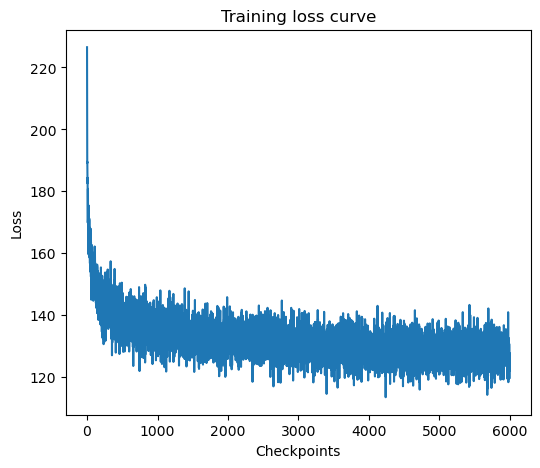

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
# we record some loss values except for the first one
# because its value is too enormous
plt.plot(losses[1:])
plt.xlabel("Checkpoints")
plt.ylabel("Loss")
plt.title("Training loss curve")
plt.show()

## Visualization

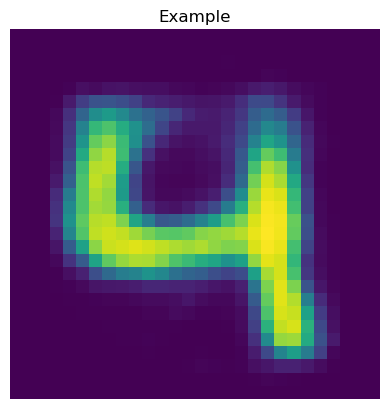

In [10]:
import numpy as np


with torch.no_grad():
    # in the generation process,
    # we only use the decoder of VAE,
    # and the input is a Gaussian noise
    z = torch.randn(64, 2).to(device)
    sample = vae.decoder(z).to(device)
    sample = sample.reshape(64, 1, 28, 28).cpu().numpy()
    sample = sample.transpose(0, 2, 3, 1)

plt.figure()
plt.axis('off') # 关掉坐标轴为 off
plt.title('Example')
# we have 64 generated images, and only visualize the first one
plt.imshow(sample[0])